# LSTM Modelling for Forecasting Carbon Market Prices

Based majority of code Jason Brownlee PhDs posts:

https://machinelearningmastery.com/understanding-stateful-lstm-recurrent-neural-networks-python-keras/

## Multivariate Time Series Forecasting with LSTMs in Keras
Source: https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/

In [2]:
import math as m
from math import sqrt
import numpy as np
from numpy import concatenate
import matplotlib.pyplot as plt 
from matplotlib import pyplot
import pandas as pd
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

In [3]:
#Inspect the dataset - transformed to differenced time sereis
df = pd.read_csv("Full_data_LSTM.csv",index_col=0)
df.describe()

,EUA_xts,EUA_futures_xts,oil_xts,gas_xts,electricity_xts,coal_xts,DAX_xts,BE500_xts,Temp_xts
count,418.000000,418.000000,418.000000,418.000000,418.000000,418.000000,418.000000,418.000000,418.000000
mean,0.000664,0.000666,-0.000005,0.000162,-0.002437,-0.000107,0.000199,0.000579,0.000015
std,0.010281,0.010345,0.009273,0.013688,0.080063,0.004087,0.003933,0.004543,0.013671
min,-0.067729,-0.067004,-0.049978,-0.048590,-0.651170,-0.025073,-0.029271,-0.018302,-0.047064
25%,-0.004270,-0.004306,-0.003587,-0.006498,-0.024863,-0.001888,-0.001393,-0.001980,-0.007469
50%,0.000827,0.000829,0.000184,-0.000284,-0.001481,-0.000161,0.000475,0.000840,0.000676
75%,0.005745,0.005721,0.003737,0.006352,0.023807,0.001373,0.002290,0.003230,0.007950
max,0.044814,0.046424,0.070132,0.058039,0.411757,0.015888,0.014655,0.015928,0.042777


In [4]:
# For modelling only EUA futures and DAX are not used, so they are dropped
df_modelling = df.drop(["EUA_futures_xts","DAX_xts"],axis=1)
# 1 indepedent variable, 6 dependent variables
df_modelling

,EUA_xts,oil_xts,gas_xts,electricity_xts,coal_xts,BE500_xts,Temp_xts
06/01/2013,-0.004774,0.001633,0.009330,0.109833,-0.000748,-0.002646,0.007520
13/01/2013,-0.016223,-0.001743,0.001681,-0.000957,-0.001442,-0.000155,-0.038547
20/01/2013,-0.023320,0.003463,0.004951,-0.012797,-0.000561,0.005292,0.007972
27/01/2013,-0.025752,-0.000998,-0.006767,-0.008312,0.002129,0.005445,-0.004997
03/02/2013,0.011190,-0.000654,0.005494,-0.046832,0.001327,0.004090,0.030381
...,...,...,...,...,...,...,...
06/12/2020,0.004813,-0.000515,0.009711,-0.022117,0.014817,0.005655,-0.021322
13/12/2020,0.004393,0.002742,0.005534,-0.005668,0.005164,-0.001883,0.007800
20/12/2020,0.000495,0.002969,0.000787,-0.014723,0.002707,0.002592,0.012748
25/12/2020,0.009838,0.000296,0.027255,-0.141120,0.003289,0.004999,-0.009622


In [5]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg
 
# load dataset
dataset = df_modelling
values = dataset.values

In [6]:
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, 4, 1)
reframed

,var1(t-4),var2(t-4),var3(t-4),var4(t-4),var5(t-4),var6(t-4),var7(t-4),var1(t-3),var2(t-3),var3(t-3),...,var5(t-1),var6(t-1),var7(t-1),var1(t),var2(t),var3(t),var4(t),var5(t),var6(t),var7(t)
4,0.559386,0.429696,0.543193,0.715951,0.593855,0.457393,0.607554,0.457663,0.401587,0.471453,...,0.664087,0.693762,0.468232,0.701239,0.410658,0.507219,0.568560,0.644512,0.654163,0.862019
5,0.457663,0.401587,0.471453,0.611719,0.576900,0.530141,0.094799,0.394598,0.444930,0.502123,...,0.644512,0.654163,0.862019,0.605666,0.431426,0.472090,0.644336,0.614548,0.486653,0.308245
6,0.394598,0.444930,0.502123,0.600580,0.598427,0.689283,0.612592,0.372992,0.407790,0.392227,...,0.614548,0.486653,0.308245,0.775274,0.413709,0.417353,0.648592,0.579739,0.437688,0.696333
7,0.372992,0.407790,0.392227,0.604800,0.664087,0.693762,0.468232,0.701239,0.410658,0.507219,...,0.579739,0.437688,0.696333,0.503142,0.392827,0.731181,0.610469,0.575716,0.530730,0.457558
8,0.701239,0.410658,0.507219,0.568560,0.644512,0.654163,0.862019,0.605666,0.431426,0.472090,...,0.575716,0.530730,0.457558,0.574272,0.395252,0.684571,0.602613,0.606528,0.530552,0.614128
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
413,0.729582,0.482384,0.601051,0.700149,0.760752,0.944932,0.488308,0.641902,0.466567,0.452508,...,0.865859,0.573600,0.594867,0.644572,0.411815,0.546763,0.591812,0.973859,0.699895,0.286525
414,0.641902,0.466567,0.452508,0.551543,0.632707,0.594534,0.462642,0.604780,0.467151,0.404668,...,0.973859,0.699895,0.286525,0.640838,0.438930,0.507594,0.607287,0.738184,0.479665,0.610679
415,0.604780,0.467151,0.404668,0.669900,0.673173,0.529830,0.494190,0.679828,0.476483,0.599321,...,0.738184,0.479665,0.610679,0.606209,0.440817,0.463073,0.598768,0.678212,0.610409,0.665751
416,0.679828,0.476483,0.599321,0.636774,0.865859,0.573600,0.594867,0.644572,0.411815,0.546763,...,0.678212,0.610409,0.665751,0.689227,0.418566,0.711296,0.479854,0.692422,0.680713,0.416752


In [7]:
# drop columns we don't need
reframed
reframed.drop(reframed.iloc[:,29:35], axis=1, inplace=True)
reframed.drop(reframed.columns[[0,1,3,5,6,8,9,10,11,12,13,14,15,16,17,18,19,20]], axis=1, inplace=True)


print(reframed.head())
# I always use a 1 lagged version of all covariates and the EUA time series to predict the EUA time series tomorrow 

   var3(t-4)  var5(t-4)  var1(t-3)  var1(t-1)  var2(t-1)  var3(t-1)  \
4   0.543193   0.593855   0.457663   0.372992   0.407790   0.392227   
5   0.471453   0.576900   0.394598   0.701239   0.410658   0.507219   
6   0.502123   0.598427   0.372992   0.605666   0.431426   0.472090   
7   0.392227   0.664087   0.701239   0.775274   0.413709   0.417353   
8   0.507219   0.644512   0.605666   0.503142   0.392827   0.731181   

   var4(t-1)  var5(t-1)  var6(t-1)  var7(t-1)   var1(t)  
4   0.604800   0.664087   0.693762   0.468232  0.701239  
5   0.568560   0.644512   0.654163   0.862019  0.605666  
6   0.644336   0.614548   0.486653   0.308245  0.775274  
7   0.648592   0.579739   0.437688   0.696333  0.503142  
8   0.610469   0.575716   0.530730   0.457558  0.574272  


### Base LSTM Model Setup - Forecast just for showing working solution

In [8]:
# split into train and test sets for modelling
values = reframed.values
n_train_weeks = 260 #train on first 5 years 2013-2017, test on 1 year 2018, overall prediction results on 2019-2020
train = values[:n_train_weeks, :]
test = values[n_train_weeks:311, :] # test on 1 year 2018 to build model

# For Comparison for other values - train on the first 


# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]

# OVERALL TRAIN AND TEST SPLIT FOR FORECAST PERFORMANCE 
values = reframed.values
n_train_weeks = 311 #2013-2018 as "full training set",overall prediction results on 2019-2020
train_full = values[:n_train_weeks, :]
test_full = values[n_train_weeks:, :] # test on 2 years 2018-2019 to check forecast performance

# For Comparison for other values - train on the first 


# split into input and outputs
train_X_full, train_y_full = train_full[:, :-1], train_full[:, -1]
test_X_full, test_y_full = test_full[:, :-1], test_full[:, -1]
#Reshape for prediction
train_X_full = train_X_full.reshape((train_X_full.shape[0], 1, train_X_full.shape[1]))
test_X_full = test_X_full.reshape((test_X_full.shape[0], 1, test_X_full.shape[1]))

# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)


(260, 1, 10) (260,) (51, 1, 10) (51,)


Epoch 1/50
Epoch 2/50
Epoch 3/50
Epoch 4/50
Epoch 5/50
Epoch 6/50
Epoch 7/50
Epoch 8/50
Epoch 9/50
Epoch 10/50
Epoch 11/50
Epoch 12/50
Epoch 13/50
Epoch 14/50
Epoch 15/50
Epoch 16/50
Epoch 17/50
Epoch 18/50
Epoch 19/50
Epoch 20/50
Epoch 21/50
Epoch 22/50
Epoch 23/50
Epoch 24/50
Epoch 25/50
Epoch 26/50
Epoch 27/50
Epoch 28/50
Epoch 29/50
Epoch 30/50
Epoch 31/50
Epoch 32/50
Epoch 33/50
Epoch 34/50
Epoch 35/50
Epoch 36/50
Epoch 37/50
Epoch 38/50
Epoch 39/50
Epoch 40/50
Epoch 41/50
Epoch 42/50
Epoch 43/50
Epoch 44/50
Epoch 45/50
Epoch 46/50
Epoch 47/50
Epoch 48/50
Epoch 49/50
Epoch 50/50


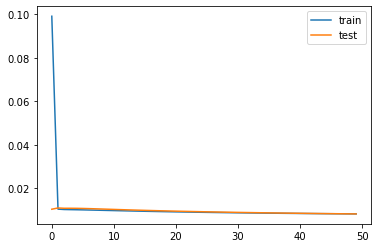

Test RMSE: 0.010


In [9]:
# design network
model = Sequential()
model.add(LSTM(20, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=5, validation_data=(test_X, test_y), verbose=3, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show() 

# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, -6:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, -6:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

### LSTM Modelling and Prediction - mulitvariate, direct 1-step rolling window forecast

In [22]:
# make a prediction of 1 step ahead, then revaluate the model with new training data from week 2:261 and test on 261:313 etc. 
predictions=list()
real_values=list()
RMSE_LSTM1step=list()

In [23]:
def step1_forecast(forecast_steps_into_future,test_y_full,test_X_full):
    for i in range(forecast_steps_into_future):
        
        # split into train and test sets for modelling
        values = reframed.values
        n_train_weeks = 259 #train on first 5 years 2013-2017, test on 1 year 2018, overall prediction results on 2019-2020
        train = values[i:n_train_weeks+i, :]
        test = values[i+n_train_weeks:311+i, :] # test on 1 year 2018 to build model

        # split into input and outputs
        train_X, train_y = train[:, :-1], train[:, -1]
        test_X, test_y = test[:, :-1], test[:, -1]

        # reshape input to be 3D [samples, timesteps, features]
        train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
        test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
    
        # design network
        model = Sequential()
        model.add(LSTM(20, input_shape=(train_X.shape[1], train_X.shape[2])))
        model.add(Dense(1))
        model.compile(loss='mean_squared_error', optimizer='adam')
        # fit network
        history = model.fit(train_X, train_y, epochs=50, batch_size=10, validation_data=(test_X, test_y), verbose=3, shuffle=False)
        print()
        print("Counter for Modelling performed",i+1)
        print()
        # plot history
        #pyplot.plot(history.history['loss'], label='train')
        #pyplot.plot(history.history['val_loss'], label='test')
        #pyplot.legend()
        #pyplot.show() 

        yhat = model.predict(test_X_full[[i]])
        #Reshape back after prediction
        test_X_full_back = test_X_full.reshape((test_X_full.shape[0], test_X_full.shape[2]))
        
        # invert scaling for forecast
        inv_yhat = concatenate((yhat[0], test_X_full_back[i, -6:]), axis=0)
        inv_yhat = inv_yhat.reshape(1, -1)
        inv_yhat = scaler.inverse_transform(inv_yhat)
        inv_yhat = inv_yhat[:,0]
        predictions.append(inv_yhat[0])

        # invert scaling for actual
        test_y_full = test_y_full.reshape((len(test_y_full), 1))
        inv_y = concatenate((test_y_full[i], test_X_full_back[i, -6:]), axis=0)
        inv_y = inv_y.reshape(1,-1)
        inv_y = scaler.inverse_transform(inv_y)
        inv_y = inv_y[:,0]
        real_values.append(inv_y[0])
        # calculate RMSE
        rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
        print(rmse)
        RMSE_LSTM1step.append(rmse)
    return
    
step1_forecast(103,test_y_full,test_X_full)

Epoch 1/50
Epoch 2/50
Epoch 3/50
Epoch 4/50
Epoch 5/50
Epoch 6/50
Epoch 7/50
Epoch 8/50
Epoch 9/50
Epoch 10/50
Epoch 11/50
Epoch 12/50
Epoch 13/50
Epoch 14/50
Epoch 15/50
Epoch 16/50
Epoch 17/50
Epoch 18/50
Epoch 19/50
Epoch 20/50
Epoch 21/50
Epoch 22/50
Epoch 23/50
Epoch 24/50
Epoch 25/50
Epoch 26/50
Epoch 27/50
Epoch 28/50
Epoch 29/50
Epoch 30/50
Epoch 31/50
Epoch 32/50
Epoch 33/50
Epoch 34/50
Epoch 35/50
Epoch 36/50
Epoch 37/50
Epoch 38/50
Epoch 39/50
Epoch 40/50
Epoch 41/50
Epoch 42/50
Epoch 43/50
Epoch 44/50
Epoch 45/50
Epoch 46/50
Epoch 47/50
Epoch 48/50
Epoch 49/50
Epoch 50/50

Counter for Modelling performed 1

0.01355081631776061
Epoch 1/50
Epoch 2/50
Epoch 3/50
Epoch 4/50
Epoch 5/50
Epoch 6/50
Epoch 7/50
Epoch 8/50
Epoch 9/50
Epoch 10/50
Epoch 11/50
Epoch 12/50
Epoch 13/50
Epoch 14/50
Epoch 15/50
Epoch 16/50
Epoch 17/50
Epoch 18/50
Epoch 19/50
Epoch 20/50
Epoch 21/50
Epoch 22/50
Epoch 23/50
Epoch 24/50
Epoch 25/50
Epoch 26/50
Epoch 27/50
Epoch 28/50
Epoch 29/50
Epoch 30/50
Ep

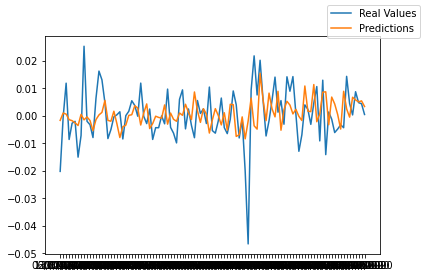

In [25]:
#create final table with results
final_table_LSTM1step=pd.DataFrame(list(zip(predictions)),index=dataset.index[313:416],columns=["Predictions"])
final_table_LSTM1step["Real Values"] = df_modelling.loc[df_modelling.index[313:416],"EUA_xts"]
final_table_LSTM1step["RMSE"] = ((final_table_LSTM1step["Real Values"]-final_table_LSTM1step["Predictions"])**2)**(1/2)

plt.plot(final_table_LSTM1step["Real Values"],label = "Real Values")
plt.plot(final_table_LSTM1step["Predictions"],label = "Predictions")

plt.figlegend()


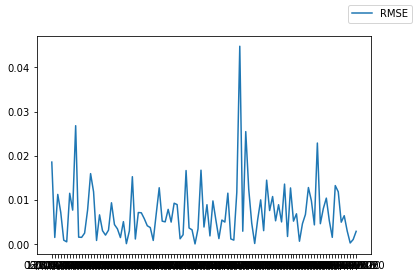

In [26]:
plt.plot(final_table_LSTM1step["RMSE"],label="RMSE")
plt.figlegend()

In [27]:
final_table_LSTM1step

# Real Values and RMSE are not accruate due to incorrect inverse_transformation
# Predictions are still correct and Real Values can be easily adjust with just inserting the real values from the test_data set

,Predictions,Real Values,RMSE
06/01/2019,-0.001659,-0.020223,0.018564
13/01/2019,0.001013,-0.000508,0.001521
20/01/2019,0.000636,0.011892,0.011257
27/01/2019,-0.001401,-0.008602,0.007201
03/02/2019,-0.001766,-0.002677,0.000911
...,...,...,...
22/11/2020,0.006778,0.000334,0.006443
29/11/2020,0.005803,0.008781,0.002978
06/12/2020,0.005087,0.004813,0.000274
13/12/2020,0.005450,0.004393,0.001057


In [28]:
sum(final_table_LSTM1step["RMSE"])

0.7273314993096923

In [29]:
#Check Directional accuracy:

def mda(actual: np.ndarray, predicted: np.ndarray):
    """ Mean Directional Accuracy """
    return np.mean((np.sign(actual[1:] - actual[:-1]) == np.sign(predicted[1:] - predicted[:-1])).astype(int))


mda(final_table_LSTM1step["Real Values"],final_table_LSTM1step["Predictions"])

0.9805825242718447

In [ ]:
#Best performing 1 step sum(RMSE): 0.7445934691493489
#Best performing:
#epochs ~50 
#batch 10 
#optimizer RMSE
#neurons: 20


In [31]:
#Create CSV File to use and compare with other models in R
final_table_LSTM1step.to_csv("Results_LSTM1step.csv")

### LSTM Modelling and Prediction - mulitvariate, direct 4-step rolling window forecast

In [98]:
#Create helper matrix
rows = 26
cols = 4
helper_matrix = ([[1*cols*y + 1*x for x in range(cols)] for y in range(rows)])

In [99]:
# empty before running for loop
predictions4step =list()
real_values4step =list()
RMSE_LSTM4step=list()


In [ ]:
def step4_forecast(forecast_steps_into_future,test_y_full,test_X_full):
    for i in range(forecast_steps_into_future):
        
        # split into train and test sets for modelling
        values = reframed.values
        n_train_weeks = 259 #train on first 5 years 2013-2017, test on 1 year 2018, overall prediction results on 2019-2020
        train = values[helper_matrix[i][0]:n_train_weeks+helper_matrix[i][0], :]
        test = values[helper_matrix[i][0]+n_train_weeks:311+helper_matrix[i][0], :] # test on 1 year 2018 to build model

        # split into input and outputs
        train_X, train_y = train[:, :-1], train[:, -1]
        test_X, test_y = test[:, :-1], test[:, -1]

        # reshape input to be 3D [samples, timesteps, features]
        train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
        test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
    
        # design network
        model = Sequential()
        model.add(LSTM(20, input_shape=(train_X.shape[1], train_X.shape[2])))
        model.add(Dense(1))
        model.compile(loss='mean_squared_error', optimizer='adam')
        # fit network
        history = model.fit(train_X, train_y, epochs=50, batch_size=10, validation_data=(test_X, test_y), verbose=2, shuffle=False)
        print()
        print("Counter for Modelling performed",i+1)
        print()
        # plot history
        #pyplot.plot(history.history['loss'], label='train')
        #pyplot.plot(history.history['val_loss'], label='test')
        #pyplot.legend()
        #pyplot.show() 

        yhat = model.predict(test_X_full[helper_matrix[i]])
        #Reshape back after prediction
        test_X_full_back = test_X_full.reshape((test_X_full.shape[0], test_X_full.shape[2]))
        
        # invert scaling for forecast
        inv_yhat = concatenate((yhat[0:4], test_X_full_back[helper_matrix[i], -6:]), axis=1)
        inv_yhat = scaler.inverse_transform(inv_yhat)
        inv_yhat = inv_yhat[:,0]
        predictions4step.append(inv_yhat)

        # invert scaling for actual
        test_y_full = test_y_full.reshape((len(test_y_full), 1))
        inv_y = concatenate((test_y_full[helper_matrix[i]], test_X_full_back[helper_matrix[i], -6:]), axis=1)
        inv_y = scaler.inverse_transform(inv_y)
        inv_y = inv_y[:,0]
        real_values4step.append(inv_y)
        # calculate RMSE
        rmse = sqrt(mean_squared_error(inv_y[helper_matrix[0]], inv_yhat[helper_matrix[0]]))
        RMSE_LSTM4step.append(rmse)
    return
    
step4_forecast(25,test_y_full,test_X_full)

In [101]:
# Reshape real values, predictions to 1 column array
predictions4step = np.reshape(predictions4step, (100, 1))
real_values4step = np.reshape(real_values4step, (100, 1))
#RMSE just works sometimes, calculated own my own in next cell

In [102]:
final_table_LSTM4step=pd.DataFrame(list(zip(predictions4step)),index=dataset.index[313:413],columns=["Predictions"])
final_table_LSTM4step["Real Values"] = df_modelling.loc[df_modelling.index[313:413],"EUA_xts"]

final_table_LSTM4step["Predictions"] = final_table_LSTM4step["Predictions"].str[0]
#calculated RMSE on my own 
final_table_LSTM4step["RMSE"] = ((final_table_LSTM4step["Real Values"]-final_table_LSTM4step["Predictions"])**2)**(1/2)


In [103]:
final_table_LSTM4step

,Predictions,Real Values,RMSE
06/01/2019,-0.000413,-0.020223,0.019810
13/01/2019,0.000923,-0.000508,0.001431
20/01/2019,0.000151,0.011892,0.011741
27/01/2019,-0.001505,-0.008602,0.007097
03/02/2019,-0.002365,-0.002677,0.000312
...,...,...,...
01/11/2020,0.010995,-0.004320,0.015315
08/11/2020,0.002304,0.014380,0.012076
15/11/2020,0.000691,0.004512,0.003821
22/11/2020,0.008136,0.000334,0.007801


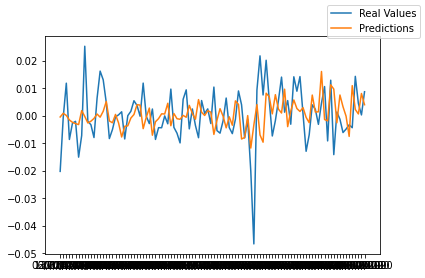

In [104]:
plt.plot(final_table_LSTM4step["Real Values"],label = "Real Values")
plt.plot(final_table_LSTM4step["Predictions"],label = "Predictions")
plt.figlegend()

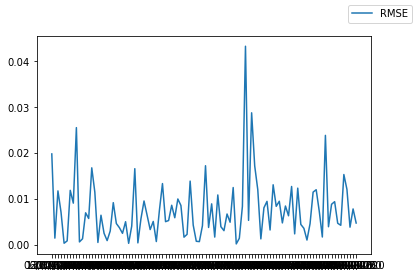

In [105]:
plt.plot(final_table_LSTM4step["RMSE"],label="RMSE")
plt.figlegend()

In [106]:
sum(final_table_LSTM4step["RMSE"])

0.7469709385073677

In [ ]:
#Best performing 4step sum(RMSE): 4.33520
#Best performing: Higher epochs ~20 and batch at around 10 

#Further Parameter tuning possible - neurons, optimizer, loss

In [107]:
#Create CSV File to use and compare with other models in R
final_table_LSTM4step.to_csv("Results_LSTM4step.csv")

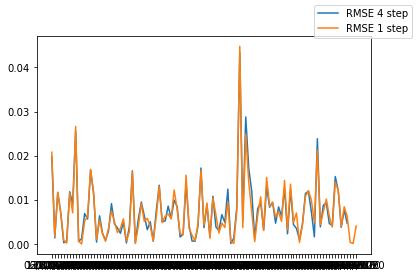

In [108]:
#Double check visually
plt.plot(final_table_LSTM4step["RMSE"],label = "RMSE 4 step")
plt.plot(final_table_LSTM1step["RMSE"],label = "RMSE 1 step")
plt.figlegend()

In [ ]:
# MODELLING DONE
# PARAMETER TUNING DONE
# DONE!